# sdAb conformational analysis
We look at three single-domain antibodies designed using three different approaches and examine their conformational properties, especially their complementarity determining regions.

In [1]:
import itertools
import os
from pathlib import Path

import colorcet as cc
import numba
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_hex
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pyemma as pe
import mdtraj as md
import seaborn as sns
from scipy.stats import gaussian_kde

rc("font", **{"family": "sans-serif",
              "sans-serif": ["Helvetica"]})
plt.rcParams['svg.fonttype'] = 'none'
colors = sns.husl_palette()

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
[to_hex(c) for c in colors]

['#f77189', '#bb9832', '#50b131', '#36ada4', '#3ba3ec', '#e866f4']

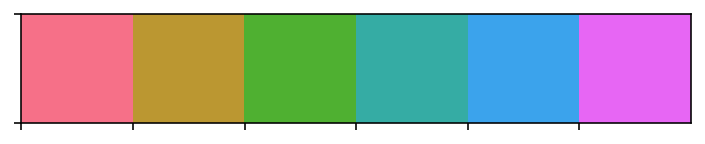

In [5]:
sns.palplot(colors)

## Useful functions

In [10]:
def triu_inverse(x: np.ndarray, n: int) -> np.ndarray:
    """
    Converts flattened upper-triangular matrices into full symmetric matrices.
    
    Parameters
    ----------
    x
        Flattened matrices
    n
        Size of the n * n matrix
    
    Returns
    -------
    mat
        Array of shape (length, n, n)
    
    """
    length = x.shape[0]
    mat = np.zeros((length, n, n))
    a, b = np.triu_indices(n, k=1)
    mat[:, a, b] = x
    mat += mat.swapaxes(1, 2)
    return mat

## Data and CDR definitions

In [11]:
KBT = 2.494339 # kJ/mol, 300K
n_replica = 32

# Short names for DesAbO, DesAb-HSA-D3, and Nb10
sim_names = ("des", "vhh", "dka")

# Biased CVs
cv_names = ["abbb", "absc", "helix", "beta"]

# Trajectories and topologies
traj_files, top_files = {}, {}
traj_files["des"] = "../trajectories/des/traj.xtc"
traj_files["vhh"] = "../trajectories/vhh/traj.xtc"
traj_files["dka"] = "../trajectories/dka/traj.xtc"

top_files = {}
top_files["des"] = "../trajectories/des/topol.pdb"
top_files["vhh"] = "../trajectories/vhh/topol.pdb"
top_files["dka"] = "../trajectories/dka/topol.pdb"

biased_cvs = {}
biased_cvs["des"] = np.loadtxt("../trajectories/des/FULLBIAS")
biased_cvs["vhh"] = np.loadtxt("../trajectories/vhh/FULLBIAS")
biased_cvs["dka"] = np.loadtxt("../trajectories/dka/FULLBIAS")

# Torrie-Valleau re-weighting based on accumulated bias
weights = {k: -np.exp(b[:, -1] / KBT) / -np.exp(b[:, -1] / KBT).sum() for k, b in biased_cvs.items()}
nframes = {k: weights[k].shape[0] for k in ("des", "vhh", "dka")}

# CDR definitions
nres = dict(des=125, vhh=128, dka=127)
cdr1_begin = dict(des=26, vhh=25, dka=25)
cdr2_begin = dict(des=50, vhh=49, dka=49)
cdr3_begin = dict(des=100, vhh=98, dka=99)
cdr1_end = dict(des=36, vhh=35, dka=35)
cdr2_end = dict(des=60, vhh=59, dka=59)
cdr3_end = dict(des=112, vhh=121, dka=117)

# Intra-CDR contacts
pairs_cdr1 = {k: np.array(list(itertools.combinations(range(cdr1_begin[k], cdr1_end[k]), 2)))
              for k in ("des", "vhh", "dka")}
pairs_cdr2 = {k: np.array(list(itertools.combinations(range(cdr2_begin[k], cdr2_end[k]), 2)))
              for k in ("des", "vhh", "dka")}
pairs_cdr3 = {k: np.array(list(itertools.combinations(range(cdr3_begin[k], cdr3_end[k]), 2)))
              for k in ("des", "vhh", "dka")}

# CDR-Nanobody contacts
cdr1con = {k: np.array(list(
    itertools.product(
        range(nres[k]),
        range(cdr1_begin[k], cdr1_end[k])
))) for k in ("des", "vhh", "dka")}

cdr2con = {k: np.array(list(
    itertools.product(
        range(nres[k]),
        range(cdr2_begin[k], cdr2_end[k])
))) for k in ("des", "vhh", "dka")}

cdr3con = {k: np.array(list(
    itertools.product(
        range(nres[k]),
        range(cdr3_begin[k], cdr3_end[k])
))) for k in ("des", "vhh", "dka")}

### CDRs

In [26]:
for k in sim_names:
    top = md.load_topology(top_files[k])
    seq = "".join(top.residue(i).code for i in range(cdr1_begin[k], cdr1_end[k]))
    print(k, seq, cdr1_begin[k] + 1, cdr1_end[k] + 1)

des GFNIKDTYIG 27 37
vhh GELYALISMG 26 36
dka GRTSSLYSMG 26 36


In [27]:
for k in sim_names:
    top = md.load_topology(top_files[k])
    seq = "".join(top.residue(i).code for i in range(cdr2_begin[k], cdr2_end[k]))
    print(k, seq, cdr2_begin[k] + 1, cdr2_end[k] + 1)

des SIYPTNGYTR 51 61
vhh AISRNGANTY 50 60
dka AISRNGANTY 50 60


In [28]:
for k in sim_names:
    top = md.load_topology(top_files[k])
    seq = "".join(top.residue(i).code for i in range(cdr3_begin[k], cdr3_end[k]))
    print(k, seq, cdr3_begin[k] + 1, cdr3_end[k] + 1)

des SESAFGRAEEEA 101 113
vhh DKFASPDGVVTIMTNEYDYWGQG 99 122
dka RFPTMEVVTIMTNEYDYW 100 118


### Full sequence

In [16]:
for k in sim_names:
    top = md.load_topology(top_files[k])
    seq = "".join(top.residue(i).code for i in range(nres[k]))
    print(k, seq[:65])
    print("   ", seq[65:])

des MEVQLVESGGGLVQPGGSLRLSCAASGFNIKDTYIGWVRRAPGKGEEWVASIYPTNGYTRYADSV
    KGRFTISADTSKNTAYLQMNSLRAEDTAVYYCAAGSESAFGRAEEEAAAWGQGTLVTVSS
vhh QVQLQESGGGLVQAGGSLRLSCAASGELYALISMGWFRQAPGKEREFVAAISRNGANTYYTDSVK
    GRFTISRDNAKNTVELQMNSLKPEDTAVYYCAADKFASPDGVVTIMTNEYDYWGQGTQVTVSS
dka QVQLQESGGGLVQAGGSLRLSCAASGRTSSLYSMGWFRQAPGKEREFVAAISRNGANTYYTDSVK
    GRFTISRDNAKNTVELQMNSLKPEDTAVYYCAADRFPTMEVVTIMTNEYDYWGQGTQVTVSS


## Clustering
Gromos clustering with a trajectory subsample, based on CA RMSD. We first evaluate different cutoffs:

In [29]:
traj = {k: md.load_xtc(traj_files[k], top_files[k]) for k in sim_names}

In [29]:
N = 10000
n_rounds = 20
for k in ("vhh", "des", "dka"):
    folder = Path(f"cluster-{k}")
    n_frames = traj[k].n_frames
    inds = np.arange(n_frames)
    top = md.load_topology(top_files[k])
    ca_inds = top.select("name CA")
    for i in range(n_rounds):
        (folder / f"r{i}").mkdir(exist_ok=True, parents=True)
        inds_sample = np.random.choice(inds, size=N, replace=False,
                                       p=weights[k] / weights[k].sum())
        traj[k][inds_sample].atom_slice(ca_inds).save_xtc((folder / f"r{i}" / f"conf-ca.xtc").as_posix())

### GROMOS clustering
Run this script inside `cluster-<name>`:
```bash
#!/bin/bash

for i in {0..19}
do
    cd r${i} && echo "Processing ${i}"
    for co in {0.01,0.02,0.05,0.1,0.12,0.15,0.2,0.4}
    do
        yes "1" | gmx_mpi cluster -f conf-ca.xtc -s ../conf-ca.pdb -method gromos -cutoff ${co} -o rmsd-${co}.xpm -g cluster-${co}.log -clid cluster-id-${co}.xvg
    done
    cd ..
done
```

In [9]:
n_rounds = 20
cutoffs = [0.01, 0.02, 0.05, 0.1, 0.12, 0.15, 0.2, 0.4]
n_clust = {}
for k in ("des", "vhh", "dka"):
    n_clust[k] = {}
    for co in cutoffs:
        n_clust[k][co] = np.empty((n_rounds,), dtype=int)
        for i in range(n_rounds):
            print(k, co, i, end="\r")
            ids = np.loadtxt(f"cluster-{k}/r{i}/cluster-id-{co}.xvg", comments=("#", "@"))
            n_clust[k][co][i] = np.unique(ids[:, 1]).shape[0]

### Ideal cutoff
We select a suitable cutoff based on the number of clusters for each ensemble:

/home/thomas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # This is added back by InteractiveShellApp.init_path()


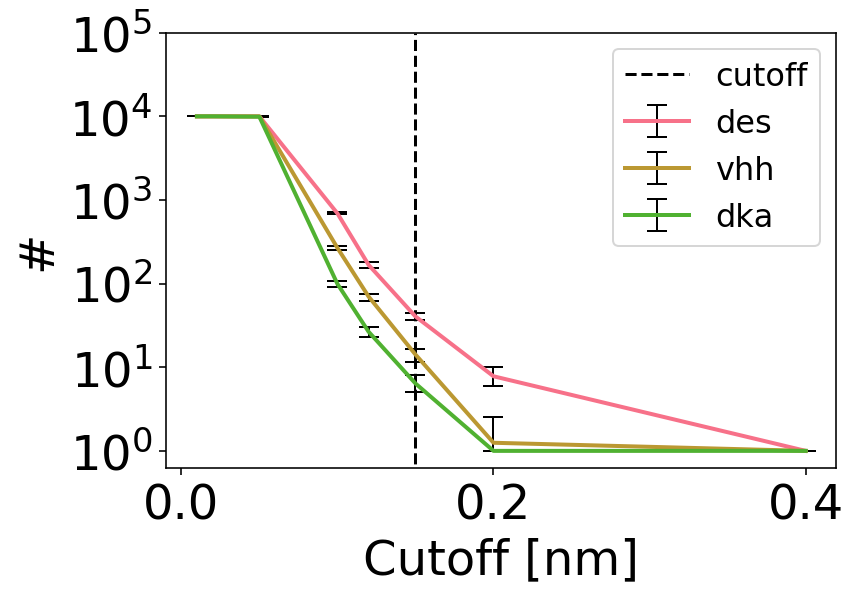

In [13]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
for i, k in enumerate(("des", "vhh", "dka")):
    x = list(n_clust[k].keys())
    ym = np.array([v.mean() for v in n_clust[k].values()])
    yp = np.array([np.percentile(v, q=(2.5, 97.5)) for v in n_clust[k].values()]).T
    ax.errorbar(x, ym, yerr=[ym - yp[0], yp[1] - ym], linewidth=2, color=colors[i], label=k, capsize=5, ecolor="k", elinewidth=1)
ax.tick_params(labelsize=24)
ax.set_yscale("log")
ax.set_yticks(np.logspace(0, 5, 6, dtype=int))
ax.set_ylim(0, 1e5)
ax.set_xlabel("Cutoff [nm]", fontsize=24)
ax.set_ylabel("#", fontsize=24)
ax.vlines(0.15, 0, 1e5, linestyles="--", label="cutoff")
ax.legend(fontsize=16)
fig.savefig(f"figs/clust-co-alt.pdf", bbox_inches="tight", transparent=True)
fig.savefig(f"figs/clust-co-alt.svg", bbox_inches="tight", transparent=True)

### Full clustering
We take a larger subsample, but as this algorithm is memory-limited we can't use the full trajectory.

In [30]:
step = 20
n_samples = 20
N = 10000

In [44]:
for k in ("des",):
    folder = Path(f"cluster-n{N}-{k}")
    folder.mkdir(exist_ok=True)
    n_frames = traj[k].n_frames
    inds = np.arange(n_frames)
    
    # bootstrap samples
    for i in range(n_samples):
        inds_sample = np.random.choice(inds, size=N, replace=True, p=weights[k])
        np.save((folder / f"inds-{i}.npy").as_posix(), inds_sample)
        top = md.load_topology(top_files[k])
        ca_inds = top.select("name CA")
        traj[k][inds_sample].atom_slice(ca_inds).save_xtc((folder / f"conf-ca-{i}.xtc").as_posix())

### GROMOS clustering
Run this script inside `cluster-n<N>-<name>`:
```bash
#!/bin/bash

for i in {0..19}
do
    yes "1" | gmx_mpi cluster -f conf-ca-${i}.xtc -s conf-ca.pdb -method gromos -cutoff 0.15 -o rmsd-${i}.xpm -g cluster-${i}.log -clid cluster-id-${i}.xvg
done
```

In [31]:
ids, inds = {}, {}
for k in ("des", "vhh", "dka"):
    ids[k] = np.empty((n_samples, N), dtype=int)
    inds[k] = np.empty((n_samples, N), dtype=int)
    for i in range(n_samples):
        ids[k][i] = np.loadtxt(f"cluster-n{N}-{k}/cluster-id-{i}.xvg", comments=("#", "@")).astype(int)[:, 1]
        inds[k][i] = np.load(f"cluster-n{N}-{k}/inds-{i}.npy").astype(int)

We need the cluster centers for the RMSF calculation later:

In [32]:
centers = {}
for k in ("des", "vhh", "dka"):
    centers[k] = np.empty((n_samples,), dtype=int)
    for i in range(n_samples):
        with open(f"cluster-n{N}-{k}/cluster-{i}.log") as f:
            for l in f.readlines():
                if l.startswith("  1"):
                    raw = int(float(l.split("|")[2].split()[0]))
                    centers[k][i] = raw if k == "vhh" else raw // 10
                    break

### Full ensemble
We also look at the cluster populations of the full ensemble:

In [33]:
counts = {}
for k in ("des", "vhh", "dka"):
    counts_list = [np.bincount(ids[k][i])[1:] for i in range(n_samples)]
    max_clust = max(len(c) for c in counts_list)
    counts[k] = np.zeros((n_samples, max_clust), dtype=int)
    for i in range(n_samples):
        counts[k][i][:len(counts_list[i])] = counts_list[i]

/home/thomas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
/home/thomas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


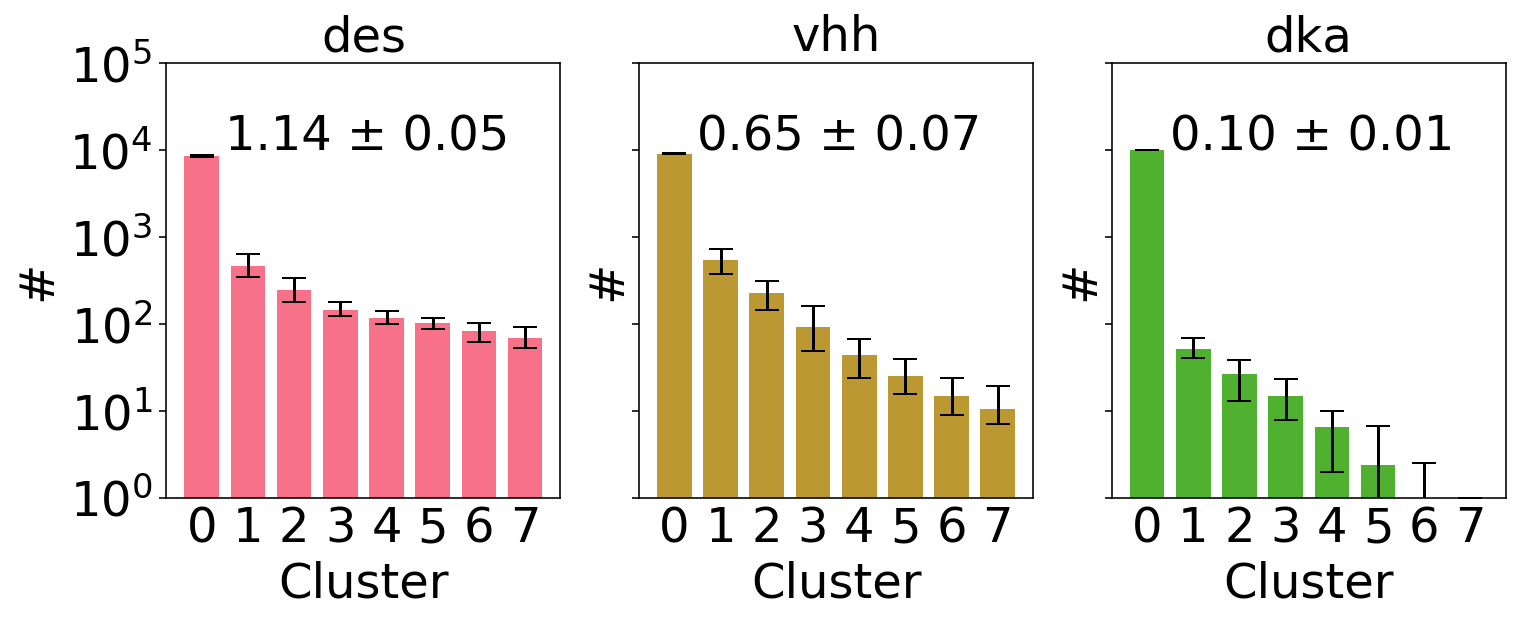

In [70]:
# n_shown = min(c.shape[1] for c in counts.values())
n_shown = 8
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for i, (k, ax) in enumerate(zip(("des", "vhh", "dka"), axes)):
    p = counts[k] / counts[k].sum(axis=1).reshape(-1, 1)
    ent = np.nansum(-p * np.log2(p), axis=1)
    x = np.arange(n_shown)
    y = counts[k].mean(axis=0)[:n_shown]
    yl, yh = np.percentile(counts[k][:, :n_shown], q=(2.5, 97.5), axis=0)
    ax.bar(x, y, width=0.75, yerr=[y - yl, yh - y], log=True, capsize=6, color=colors[i])
    ax.set_xticks(x)
    ax.tick_params(labelsize=24)
    ax.set_xticklabels(np.arange(n_shown))
    ax.set_yscale("log")
    ax.set_yticks(np.logspace(0, 5, 6, dtype=int))
    ax.set_ylim(1, 1e5)
    ax.tick_params(axis="x", length=0)
    ax.set_xlabel("Cluster", fontsize=24)
    ax.set_ylabel("#", fontsize=24)
    ax.text(0.5, 1e4, f"{ent.mean():4.2f} ± {ent.std():4.2f}", fontsize=24)
    ax.set_title(k, fontsize=24)
fig.savefig(f"figs/pop-clust.pdf", bbox_inches="tight", transparent=True)
fig.savefig(f"figs/pop-clust.svg", bbox_inches="tight", transparent=True)

/home/thomas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
/home/thomas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


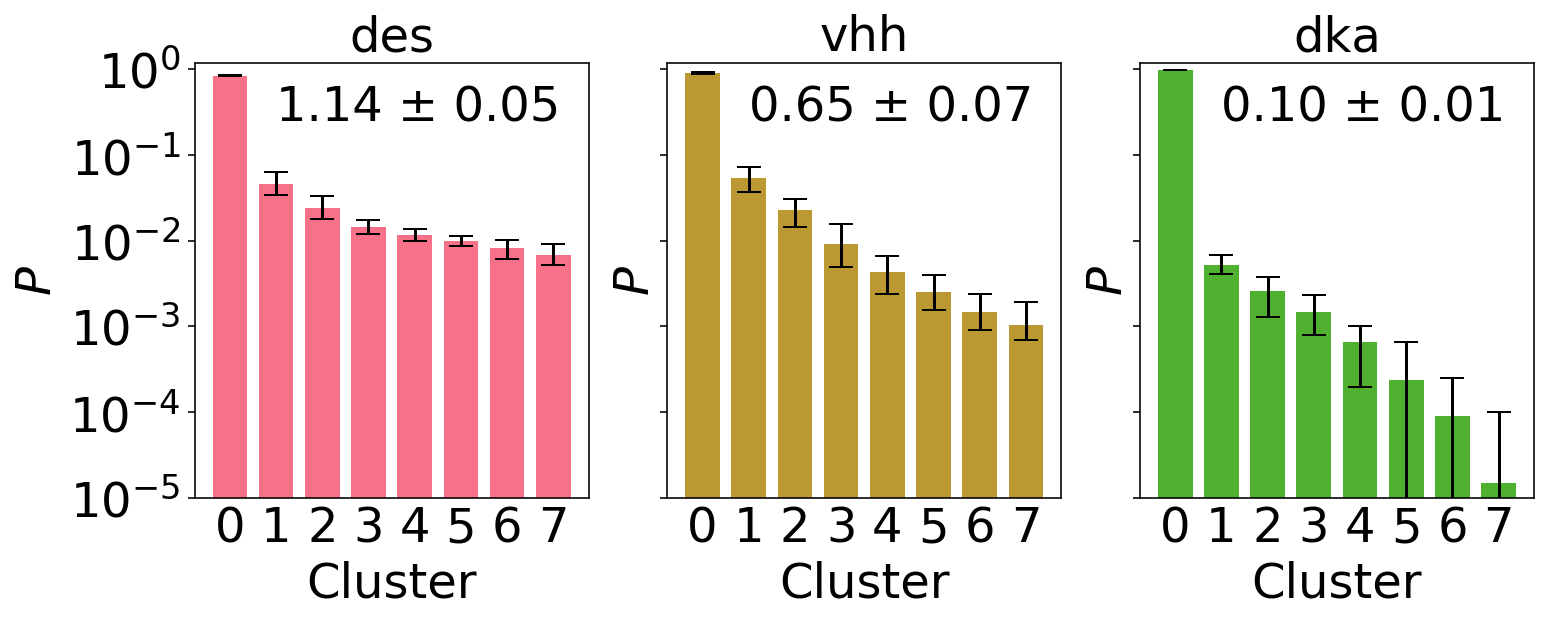

In [70]:
# n_shown = min(c.shape[1] for c in counts.values())
n_shown = 8
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for i, (k, ax) in enumerate(zip(("des", "vhh", "dka"), axes)):
    p = counts[k] / counts[k].sum(axis=1).reshape(-1, 1)
    ent = np.nansum(-p * np.log2(p), axis=1)
    x = np.arange(n_shown)
    y = p.mean(axis=0)[:n_shown]
    yl, yh = np.percentile(p[:, :n_shown], q=(2.5, 97.5), axis=0)
    ax.bar(x, y, width=0.75, yerr=[y - yl, yh - y], capsize=6, color=colors[i])
    ax.set_xticks(x)
    ax.tick_params(labelsize=24)
    ax.set_xticklabels(np.arange(n_shown))
    ax.set_yscale("log")
    ax.set_yticks(np.logspace(-5, 0, 6))
    ax.set_ylim(1e-5, 1.2)
    ax.tick_params(axis="x", length=0)
    ax.set_xlabel("Cluster", fontsize=24)
    ax.set_ylabel("$P$", fontsize=24)
    ax.text(1, 0.25, f"{ent.mean():4.2f} ± {ent.std():4.2f}", fontsize=24)
    ax.set_title(k, fontsize=24)
fig.savefig(f"figs/pop-clust-per.pdf", bbox_inches="tight", transparent=True)
fig.savefig(f"figs/pop-clust-per.svg", bbox_inches="tight", transparent=True)

## Convergence
We discard the first 20 % of the simulation and compare the cluster populations of the last two blocks.

In [47]:
counts_block = {}
for k in ("des", "vhh", "dka"):
    rep_n_frames = traj[k].n_frames // n_replica

    blocks = [
        (0, int(rep_n_frames * 0.2)),
        (int(rep_n_frames * 0.2), int(rep_n_frames * 0.2 + rep_n_frames * 0.4)),
        (int(rep_n_frames * 0.2 + rep_n_frames * 0.4), rep_n_frames)
    ]
    n_blocks = len(blocks)

    rep_range = np.arange(rep_n_frames, dtype=int)
    block_ids = np.zeros_like(rep_range)
    for j, (a, b) in enumerate(blocks):
        block_ids[(rep_range > a) & (rep_range < b)] = j

    block_mask = np.tile(block_ids, n_replica)
    n_clust = ids[k].max()
    counts_block[k] = np.zeros((n_samples, n_blocks, n_clust), dtype=int)
    for i in range(n_samples):
        for j in range(n_blocks):
            mask = block_mask[inds[k][i]] == j
            binned = np.bincount(ids[k][i][mask], minlength=n_clust + 1)
            counts_block[k][i, j] = binned[1:]

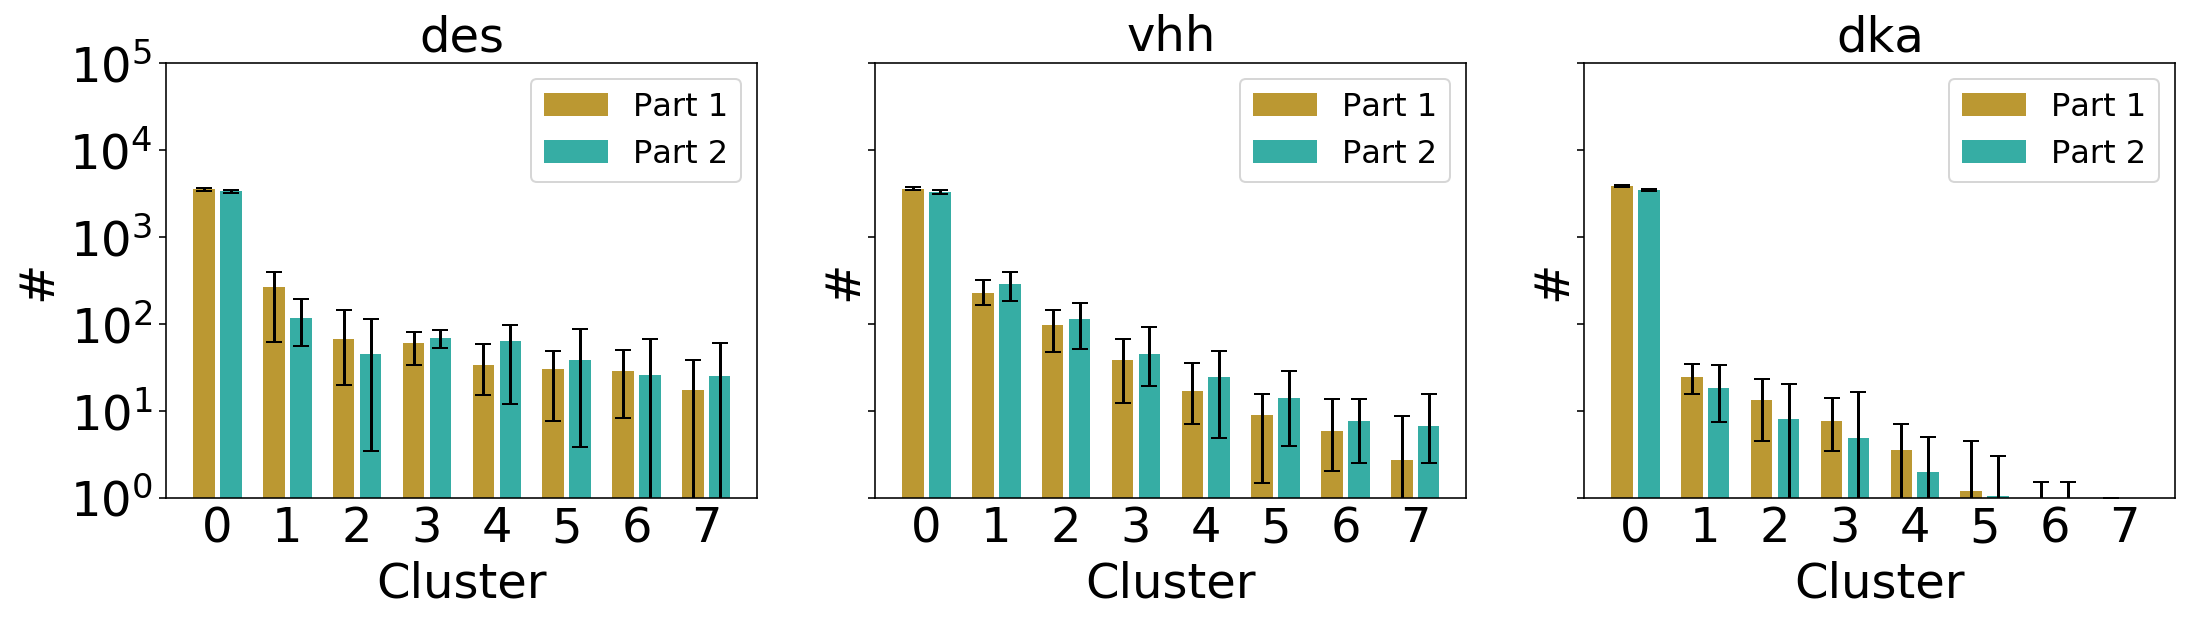

In [61]:
n_shown = 8
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)
for k, ax in zip(("des", "vhh", "dka"), axes):
    for i in range(2):
        x = np.arange(n_shown) * 1.3
        y = counts_block[k][:, i + 1].mean(axis=0)[:n_shown]
        yl, yh = np.percentile(counts_block[k][:, i + 1, :n_shown], q=(2.5, 97.5), axis=0)
        ax.bar(x + i * 0.5, y, yerr=[y - yl, yh - y], width=0.4,
               capsize=4, color=colors[i * 2 + 1], label=f"Part {i + 1}")
        ax.tick_params(labelsize=24)
        ax.set_xticks(x + 0.25)
        ax.set_xticklabels(np.arange(n_shown))
        ax.set_yscale("log")
        ax.set_yticks(np.logspace(0, 5, 6, dtype=int))
        ax.set_ylim(1, 1e5)
        ax.tick_params(axis="x", length=0)
        ax.set_xlabel("Cluster", fontsize=24)
        ax.set_ylabel("#", fontsize=24)
        ax.set_title(k, fontsize=24)
    ax.legend(fontsize=16)
fig.savefig(f"figs/conv-clust.pdf", bbox_inches="tight", transparent=True)
fig.savefig(f"figs/conv-clust.svg", bbox_inches="tight", transparent=True)

## Contacts

### CDR1 contacts
Contacts of the CDR1 with itself and the scaffold:

In [76]:
cvs1 = {}
for k in ("des", "vhh", "dka"):
    filename = f"cdr1-{k}.npy"
    if os.path.exists(filename):
        print(f"Loading existing file for {k} ensemble...")
        cvs1[k] = np.load(filename)
    else:
        print(f"No existing file for {k} ensemble, computing from scratch...")
        feat = pe.coordinates.featurizer(top_files[k])
        feat.add_custom_func(lambda x: md.compute_contacts(
            x, contacts=pairs_cdr1[k])[0].astype(np.float32), dim=pairs_cdr1[k].shape[0])
        inp = pe.coordinates.source(traj_files[k], feat)
        cvs1[k] = inp.get_output(chunk=100)[0]
        np.save(filename, cvs1[k])

No existing file for des ensemble, computing from scratch...


No existing file for vhh ensemble, computing from scratch...


No existing file for dka ensemble, computing from scratch...


Compute contacts from minimum distances and a cutoff of 0.45 nm:

In [87]:
mindist_cdr1_cdr1 = {k: cvs1[k] for k in ("des", "vhh", "dka")}

n_samples = 1
cutoff = 0.45
cdr1_con = {}
for k in ("des", "vhh", "dka"):
    cdr_len = cdr1_end[k] - cdr1_begin[k]
    cons = np.empty((n_samples, mindist_cdr1_cdr1[k].shape[1]))
    for i in range(n_samples):
        cons[i] = (mindist_cdr1_cdr1[k] < cutoff).sum(axis=0)
    cdr1_con[k] = triu_inverse(cons, cdr_len) / cvs1[k].shape[0]

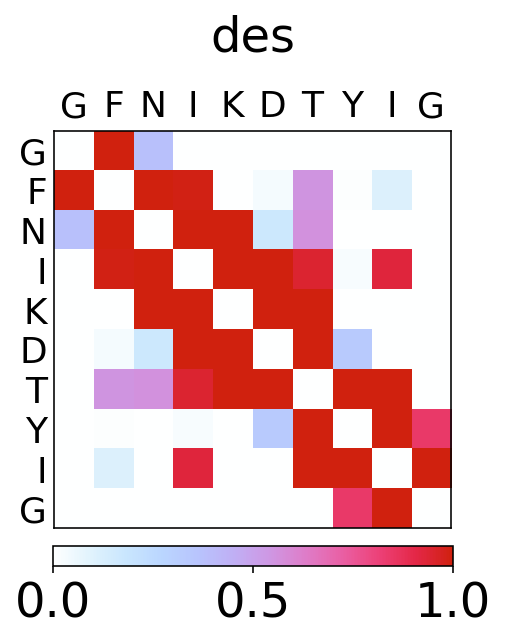

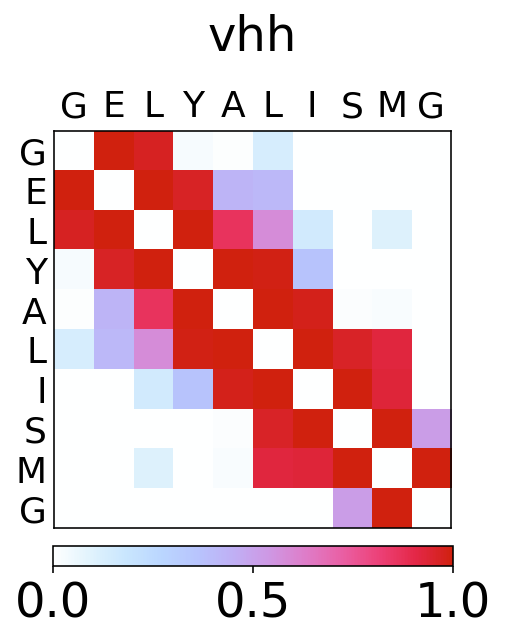

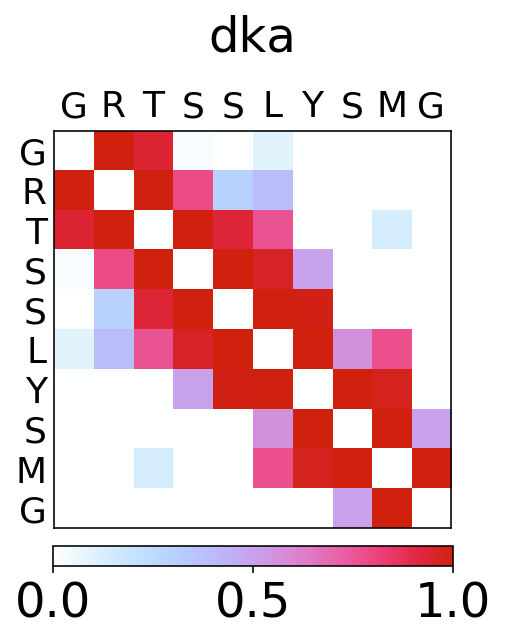

In [88]:
for i, k in enumerate(("des", "vhh", "dka")):
    topo = md.load_topology(top_files[k])
    res = "".join(r.code for r in topo.residues)[cdr1_begin[k]:cdr1_end[k]]
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    mat = cdr1_con[k].mean(axis=0)
#     cmap = LinearSegmentedColormap.from_list(k, ["#ffffff", colors[i * 4]], N=256)
    im = ax.matshow(mat, vmin=0.0, vmax=1.0, interpolation="nearest", cmap=cc.m_CET_L19)
    ax.set_xticks(np.arange(cdr1_end[k] - cdr1_begin[k]))
    ax.set_yticks(np.arange(cdr1_end[k] - cdr1_begin[k]))
    ax.set_xticklabels(res, fontsize=18)
    ax.set_yticklabels(res, fontsize=18)
    ax.tick_params(labelsize=18, length=0)
    ax.set_title(k, fontsize=24, pad=30)
    cb = fig.colorbar(im, fraction=0.046, pad=0.04, orientation="horizontal")
    cb.ax.tick_params(labelsize=24)
    fig.savefig(f"figs/cons-cdr1-{k}-alt.svg", bbox_inches="tight", transparent=True)
    fig.savefig(f"figs/cons-cdr1-{k}-alt.pdf", bbox_inches="tight", transparent=True)

### CDR2 contacts
Contacts of the CDR2 with itself and the scaffold:

In [77]:
cvs2 = {}
for k in ("des", "vhh", "dka"):
    filename = f"cdr2-{k}.npy"
    if os.path.exists(filename):
        print(f"Loading existing file for {k} ensemble...")
        cvs2[k] = np.load(filename)
    else:
        print(f"No existing file for {k} ensemble, computing from scratch...")
        feat = pe.coordinates.featurizer(top_files[k])
        feat.add_custom_func(lambda x: md.compute_contacts(
            x, contacts=pairs_cdr2[k])[0].astype(np.float32), dim=pairs_cdr2[k].shape[0])
        inp = pe.coordinates.source(traj_files[k], feat)
        cvs2[k] = inp.get_output(chunk=100)[0]
        np.save(filename, cvs2[k])

No existing file for des ensemble, computing from scratch...


No existing file for vhh ensemble, computing from scratch...


No existing file for dka ensemble, computing from scratch...


Compute contacts from minimum distances and a cutoff of 0.45 nm:

In [85]:
mindist_cdr2_cdr2 = {k: cvs2[k] for k in ("des", "vhh", "dka")}

n_samples = 1
cutoff = 0.45
cdr2_con = {}
for k in ("des", "vhh", "dka"):
    cdr_len = cdr2_end[k] - cdr2_begin[k]
    cons = np.empty((n_samples, mindist_cdr2_cdr2[k].shape[1]))
    for i in range(n_samples):
        cons[i] = (mindist_cdr2_cdr2[k] < cutoff).sum(axis=0)
    cdr2_con[k] = triu_inverse(cons, cdr_len) / cvs2[k].shape[0]

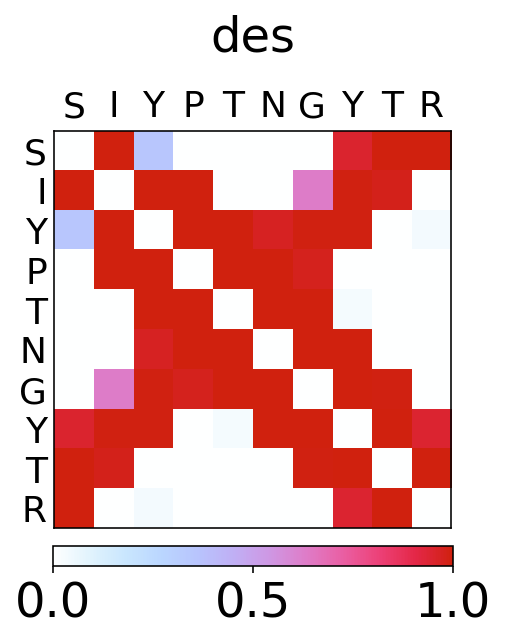

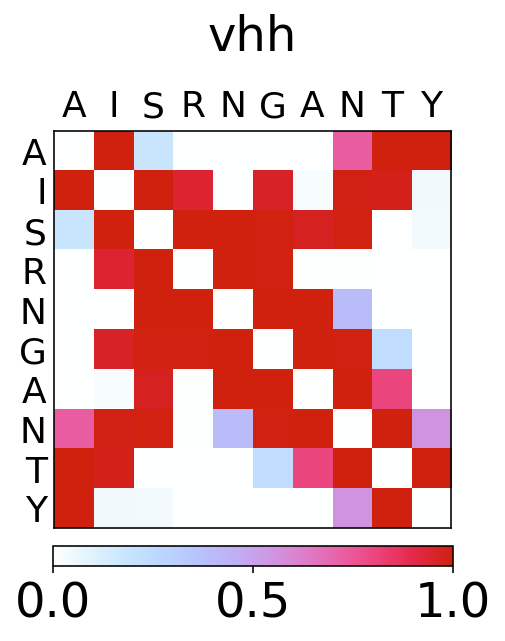

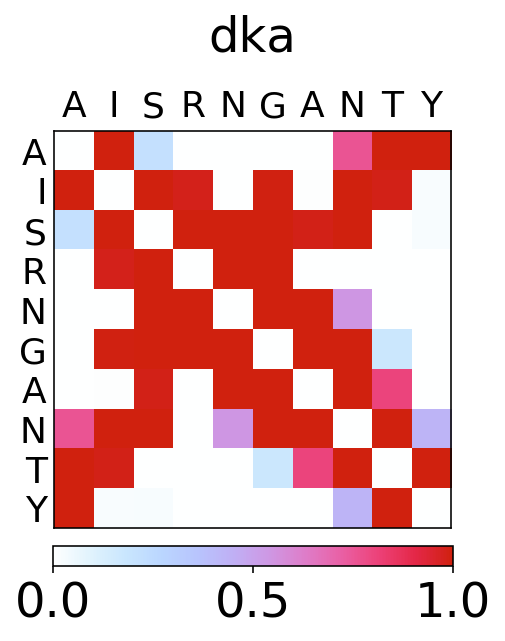

In [86]:
for i, k in enumerate(("des", "vhh", "dka")):
    topo = md.load_topology(top_files[k])
    res = "".join(r.code for r in topo.residues)[cdr2_begin[k]:cdr2_end[k]]
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    mat = cdr2_con[k].mean(axis=0)
#     cmap = LinearSegmentedColormap.from_list(k, ["#ffffff", colors[i * 4]], N=256)
    im = ax.matshow(mat, vmin=0.0, vmax=1.0, interpolation="nearest", cmap=cc.m_CET_L19)
    ax.set_xticks(np.arange(cdr2_end[k] - cdr2_begin[k]))
    ax.set_yticks(np.arange(cdr2_end[k] - cdr2_begin[k]))
    ax.set_xticklabels(res, fontsize=18)
    ax.set_yticklabels(res, fontsize=18)
    ax.tick_params(labelsize=18, length=0)
    ax.set_title(k, fontsize=24, pad=30)
    cb = fig.colorbar(im, fraction=0.046, pad=0.04, orientation="horizontal")
    cb.ax.tick_params(labelsize=24)
    fig.savefig(f"figs/cons-cdr2-{k}-alt.svg", bbox_inches="tight", transparent=True)
    fig.savefig(f"figs/cons-cdr2-{k}-alt.pdf", bbox_inches="tight", transparent=True)

### CDR3 contacts
Contacts of the CDR3 with itself and the scaffold:

In [108]:
cvs = {}
for k in ("des", "vhh", "dka"):
    filename = f"cvs-{k}.npy"
    if os.path.exists(filename):
        print(f"Loading existing file for {k} ensemble...")
        cvs[k] = np.load(filename)
    else:
        print(f"No existing file for {k} ensemble, computing from scratch...")
        feat = pe.coordinates.featurizer(top_files[k])
        feat.add_minrmsd_to_ref(ref=top_files[k])
        feat.add_custom_func(lambda x: md.compute_rg(x).reshape(-1, 1).astype(np.float32), dim=1)
        feat.add_custom_func(lambda x: md.compute_contacts(
            x, contacts=pairs_cdr3[k])[0].astype(np.float32), dim=pairs_cdr3[k].shape[0])
        feat.add_custom_func(lambda x: md.compute_contacts(
            x, contacts=cdr3con[k])[0].astype(np.float32), dim=cdr3con[k].shape[0])
        inp = pe.coordinates.source(traj_files[k], feat)
        cvs[k] = inp.get_output(chunk=1000)[0]
        np.save(f"cvs-{k}.npy", cvs[k])

No existing file for des ensemble, computing from scratch...


No existing file for vhh ensemble, computing from scratch...


Loading existing file for dka ensemble...


Sample from reduced trajectories:

In [108]:
n_samples = 20
step = 10
ens_inds = {}
for k in ("des", "vhh", "dka"):
    n_frames = weights[k][::step].shape[0]
    inds = np.arange(n_frames)
    ens_inds[k] = np.empty((n_samples, n_frames), dtype=int)
    
    # bootstrap samples
    for i in range(n_samples):
        ens_inds[k][i] = np.random.choice(inds, size=n_frames, replace=True,
                                          p=weights[k][::step] / weights[k][::step].sum())

In [111]:
change = {"vhh": 255, "des": 68, "dka": 155}
mindist_cdr_cdr = {k: cvs[k][:, 2:change[k]] for k in ("des", "vhh", "dka")}
mindist_cdr_nb = {k: cvs[k][:, change[k]:] for k in ("des", "vhh", "dka")}

cutoff = 0.5
cdr_con = {}
for k in ("des", "vhh", "dka"):
    cdr_len = cdr_end[k] - cdr_begin[k]
    cons = np.empty((n_samples, mindist_cdr_cdr[k].shape[1]))
    for i in range(n_samples):
        cons[i] = (mindist_cdr_cdr[k][::step][ens_inds[k][i]] < cutoff).sum(axis=0)
    cdr_con[k] = triu_inverse(cons, cdr_len) / ens_inds[k].shape[1]

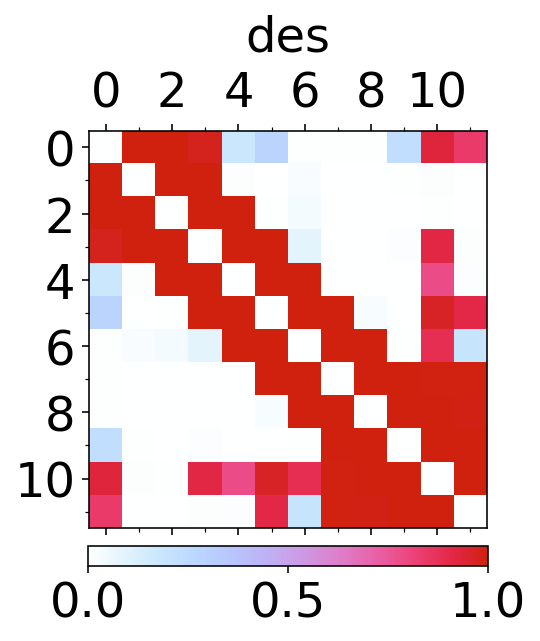

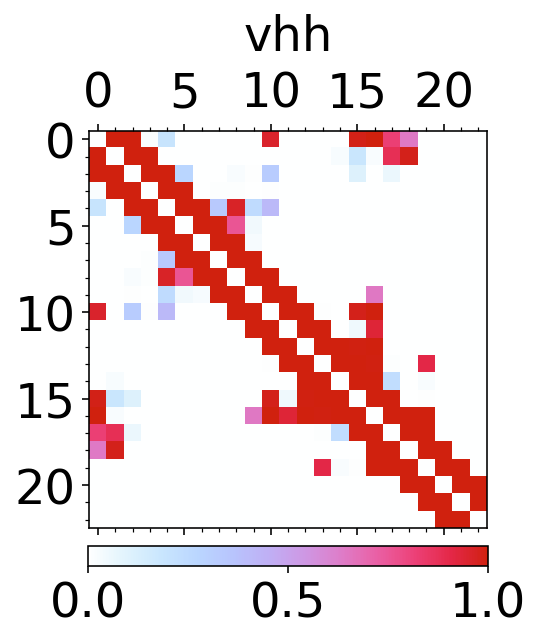

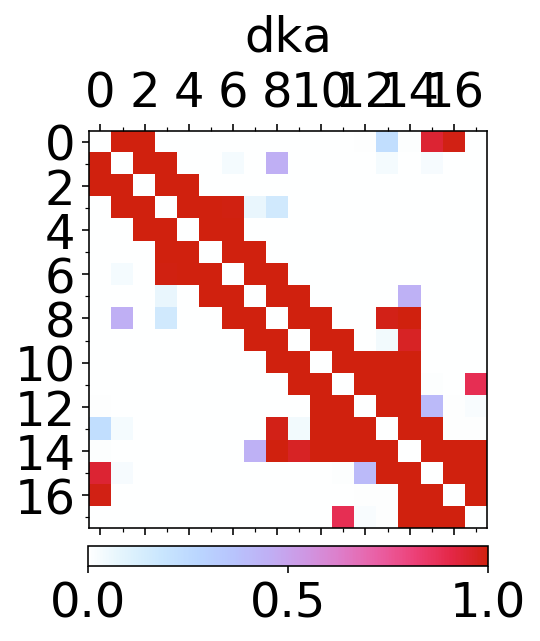

In [90]:
for i, k in enumerate(("des", "vhh", "dka")):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    mat = cdr_con[k].mean(axis=0)
#     cmap = LinearSegmentedColormap.from_list(k, ["#ffffff", colors[i * 4]], N=256)
    im = ax.matshow(mat, vmin=0.0, vmax=1.0, interpolation="nearest", cmap=cc.m_CET_L19)
    ax.set_xticks(np.arange(cdr_end[k] - cdr_begin[k]), minor=True)
    ax.set_yticks(np.arange(cdr_end[k] - cdr_begin[k]), minor=True)
    ax.tick_params(labelsize=24)
    ax.set_title(k, fontsize=24, pad=30)
    cb = fig.colorbar(im, fraction=0.046, pad=0.04, orientation="horizontal")
    cb.ax.tick_params(labelsize=24)
    fig.savefig(f"figs/cons-cdr-{k}-alt.svg", bbox_inches="tight", transparent=True)
    fig.savefig(f"figs/cons-cdr-{k}-alt.pdf", bbox_inches="tight", transparent=True)

### CDR3 – scaffold contacts

In [96]:
nb_con = {}
for k in ("des", "vhh", "dka"):
    filename = f"nbcon-{k}.npy"
    if os.path.exists(filename):
        print(f"Loading existing file for {k} ensemble...")
        nb_con[k] = np.load(filename)
    else:
        print(f"No existing file for {k} ensemble, computing from scratch...")
        cdr_len = cdr_end[k] - cdr_begin[k]
        nb_con[k] = np.zeros((n_samples, nres[k], cdr_len))
        cdrmin = cdr3con[k][:, 1].min()
        for i, (u, v) in enumerate(cdr3con[k]):
            print(f"{k}: pair {i}", end="\r")
            for j in range(n_samples):
                nb_con[k][j, u, v - cdrmin] = (mindist_cdr_nb[k][::step][ens_inds[k][j]][:, i] < cutoff).sum(axis=0)
        np.save(f"nbcon-{k}.npy", nb_con[k])

Loading existing file for des ensemble...
Loading existing file for vhh ensemble...
No existing file for dka ensemble, computing from scratch...


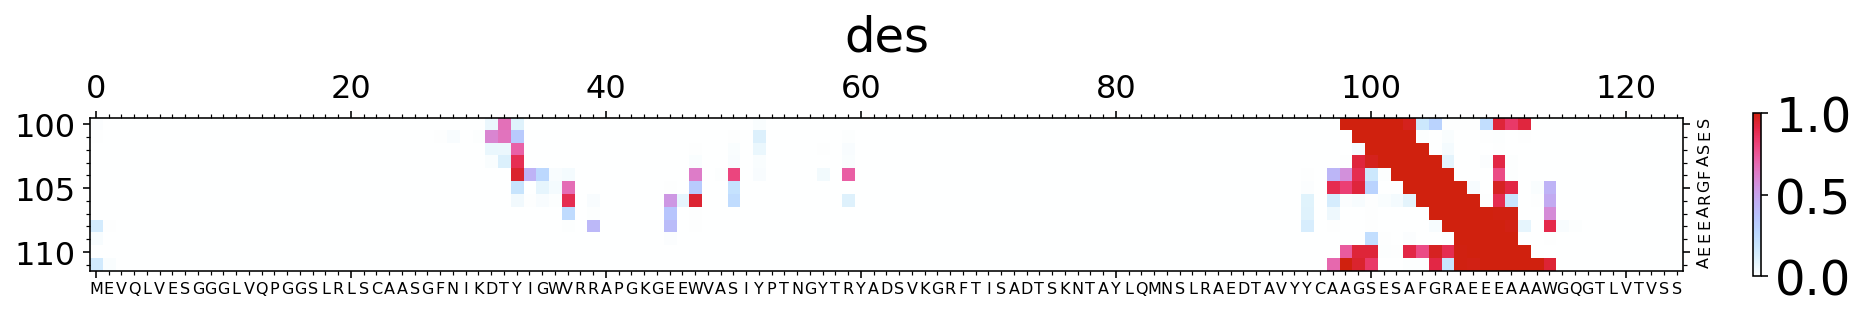

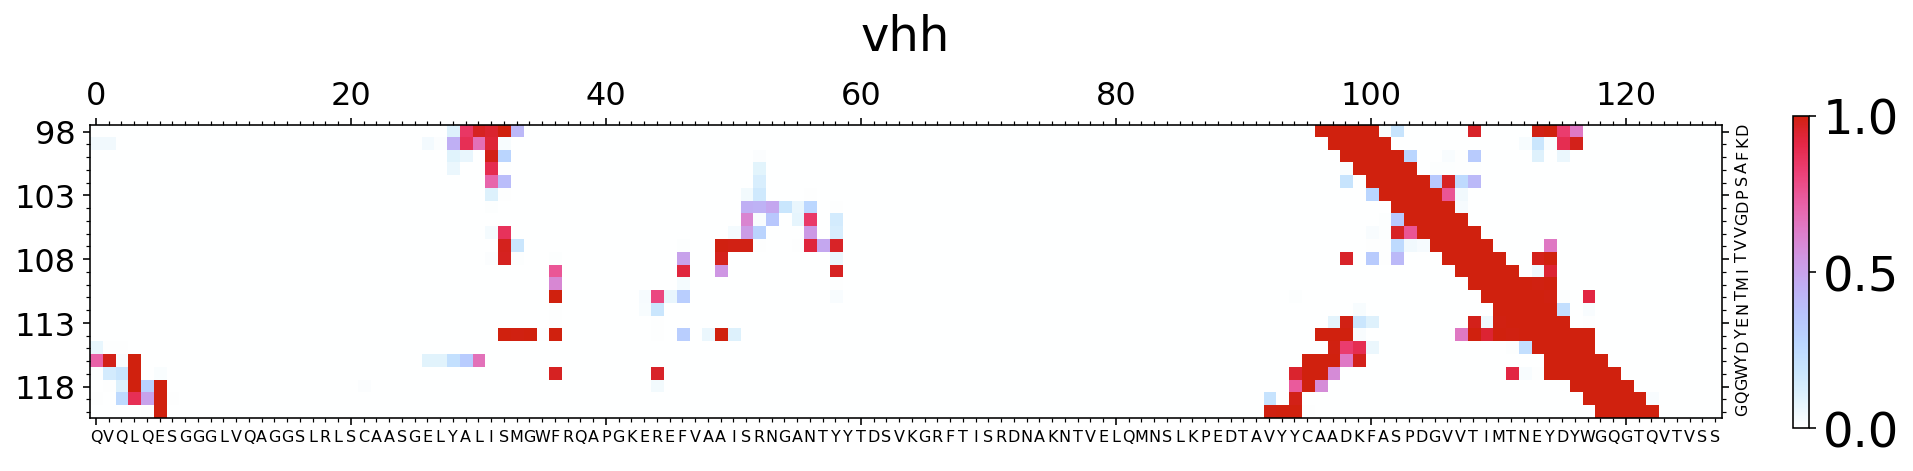

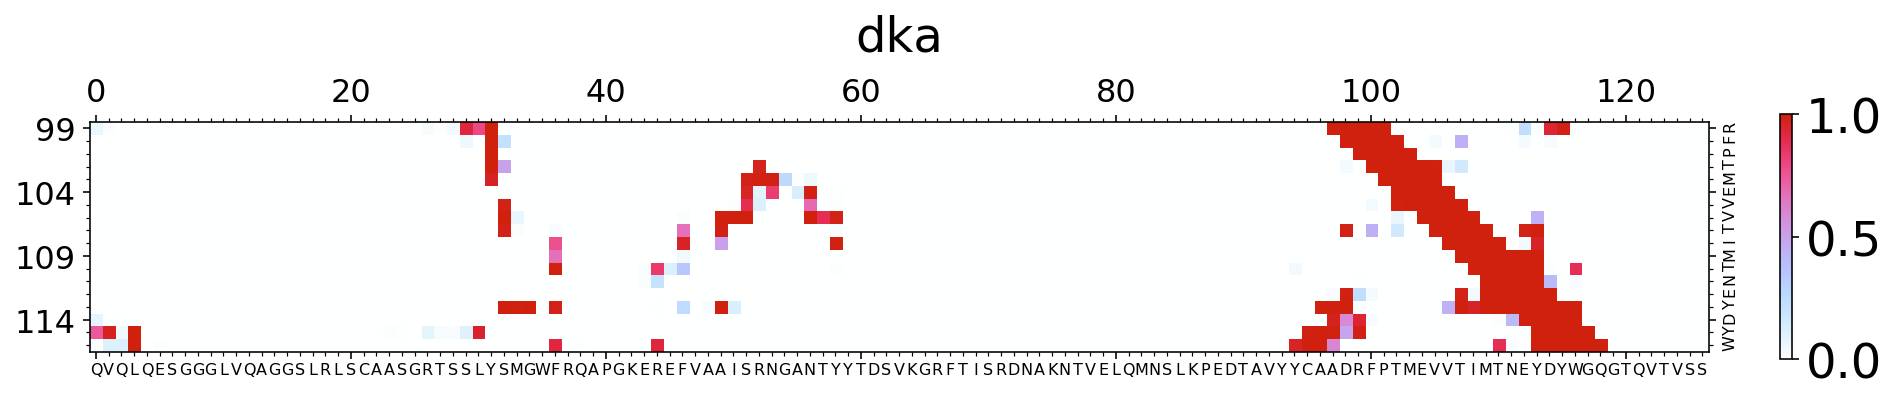

In [98]:
for i, k in enumerate(("des", "vhh", "dka")):
    top = md.load_topology(top_files[k])
    res = [r.code for r in top.residues]
    cdr_len = cdr_end[k] - cdr_begin[k]
    fig = plt.figure(figsize=(nres[k] / 8, cdr_len / 8))
    ax = fig.add_subplot(111)
    mat = (nb_con[k] / ens_inds[k].shape[1]).mean(axis=0).T
#     cmap = LinearSegmentedColormap.from_list(k, ["#ffffff", colors[i * 4]], N=256)
    cmap = cc.m_CET_L19
    im = ax.matshow(mat, vmin=0.0, vmax=1.0, interpolation="nearest", cmap=cmap)
    ax.set_xticks(np.arange(nres[k]), minor=True)
    for i, r in enumerate(res):
        ax.text(i, cdr_len + 1.25, r, fontsize=8, horizontalalignment="center")
        
    ax.set_yticks(np.arange(cdr_len), minor=True)
    ax.set_yticks(np.arange(0, cdr_len, 5), minor=False)
    ax.set_yticklabels(np.arange(cdr_begin[k], cdr_end[k] + 5, 5), minor=False)
    for i, r in enumerate(res[cdr_begin[k]:cdr_end[k]]):
        ax.text(nres[k] + 1.75, i - 0.25, r, fontsize=8, verticalalignment="center",
                horizontalalignment="right", rotation=90)
        
    ax.tick_params(labelsize=16, right=True, which="minor")
    ax.tick_params(labelsize=16, right=True, which="major")
    ax.set_title(k, fontsize=24, pad=30)
    cb = fig.colorbar(im, fraction=0.046, pad=0.04, orientation="vertical")
    cb.set_ticks([0.0, 0.5, 1.0])
    cb.ax.tick_params(labelsize=24)
    fig.savefig(f"figs/cons-cdr-nb-{k}-alt.svg", bbox_inches="tight", transparent=True)
    fig.savefig(f"figs/cons-cdr-nb-{k}-alt.pdf", bbox_inches="tight", transparent=True)

## Root-mean-square fluctuations
RMSF calculation for each residue for each ensemble, based on deviation from cluster 1 center, using a 10000 frame sample:

In [13]:
N = 10000
n_samples = 20
ens_inds = {}
for k in ("des", "vhh", "dka"):
    n_frames = traj[k].n_frames
    inds = np.arange(n_frames)
    ens_inds[k] = np.empty((n_samples, N), dtype=int)
    
    # bootstrap samples
    for i in range(n_samples):
        ens_inds[k][i] = np.random.choice(inds, size=N, replace=True, p=weights[k] / weights[k].sum())

In [18]:
n_samples = 20
rmsf = {}
for k in ("des", "vhh", "dka"):
    top = md.load_topology(top_files[k])
    atom_inds = top.select_atom_indices("alpha")
    rmsf[k] = np.empty((n_samples, atom_inds.shape[0]))
    for i in range(n_samples):
        print(f"{k} sample {i}", end="\r")
        rmsf[k][i] = md.rmsf(traj[k][ens_inds[k][i]], traj[k][centers[k][i]], atom_indices=atom_inds)

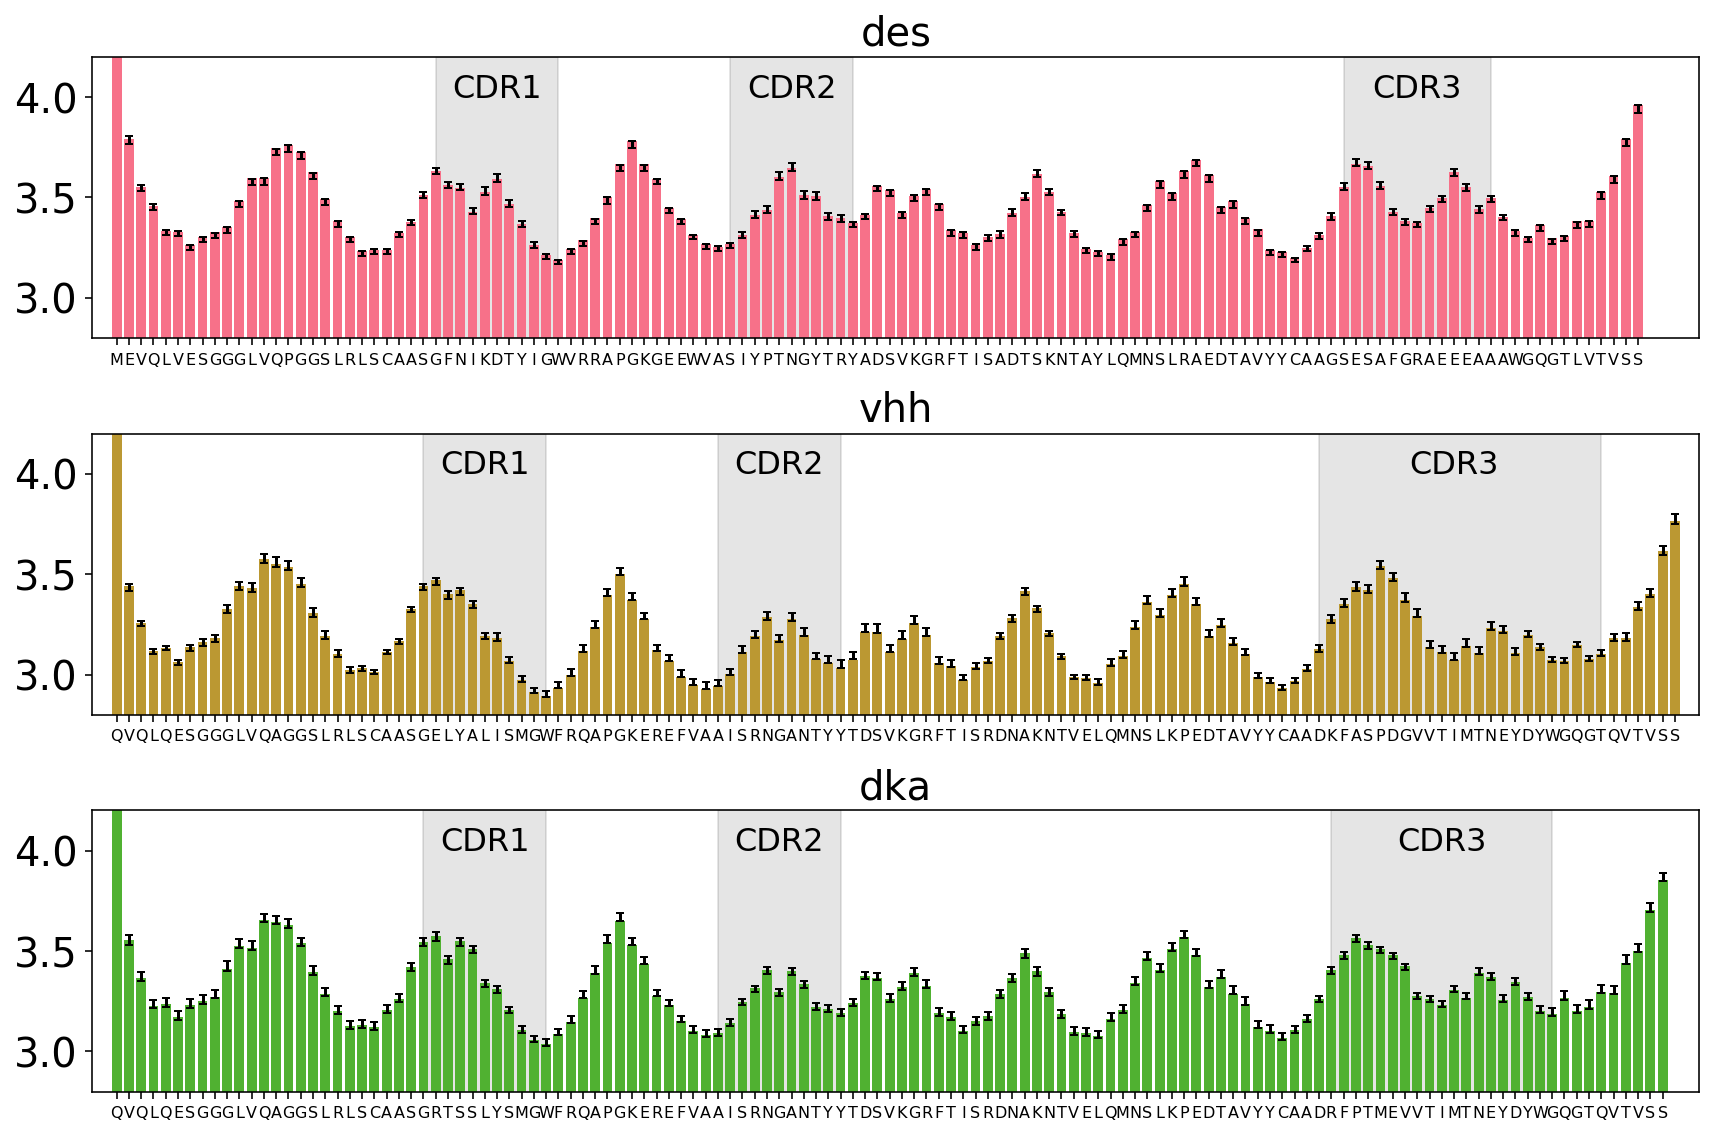

In [25]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharey=True)
for i, (ax, k) in enumerate(zip(axes, ("des", "vhh", "dka"))):
    top = md.load_topology(top_files[k])
    lab = [top.residue(r).code for r in range(0, nres[k])]
    dm, dl, dh = rmsf[k][0], *np.percentile(rmsf[k], q=(2.5, 97.5), axis=0)
    ax.axvspan(cdr1_begin[k], cdr1_end[k], color="k", alpha=0.1)
    ax.axvspan(cdr2_begin[k], cdr2_end[k], color="k", alpha=0.1)
    ax.axvspan(cdr_begin[k], cdr_end[k], color="k", alpha=0.1)
    ax.bar(np.arange(nres[k]), dm, yerr=[dm - dl, dh - dm], color=colors[i], capsize=2, ecolor="k")
    ax.text((cdr1_end[k] - cdr1_begin[k]) // 2 + cdr1_begin[k], 4.0, "CDR1", fontsize=16, ha="center")
    ax.text((cdr2_end[k] - cdr2_begin[k]) // 2 + cdr2_begin[k], 4.0, "CDR2", fontsize=16, ha="center")
    ax.text((cdr_end[k] - cdr_begin[k]) // 2 + cdr_begin[k], 4.0, "CDR3", fontsize=16, ha="center")
    ax.set_xlim(-2, max(nres.values()) + 1)
    ax.set_ylim(2.8, 4.2)
    ax.set_xticks(range(nres[k]))
    ax.tick_params(labelsize=20)
    ax.set_xticklabels(lab, fontsize=8)
    ax.set_title(f"{k}", fontsize=20)
fig.tight_layout()
fig.savefig(f"figs/rmsf-cdr-{k}-bar.svg", bbox_inches="tight", transparent=True)
fig.savefig(f"figs/rmsf-cdr-{k}-bar.pdf", bbox_inches="tight", transparent=True)

## Free energy surfaces
Our two CVs are related to the number of contacts within the CDR3 (x-axis) and between the CDR3 and the scaffold (y-axis). Specifically, we calculate the average number of contacts per residue and normalise this value to fall between 0 and 1:

In [112]:
cutoff = 0.45
contacts = {k: np.empty((nframes[k], 2)) for k in ("des", "vhh", "dka")}
for k in ("des", "vhh", "dka"):
    cdr_len = cdr_end[k] - cdr_begin[k]
    con_temp = (mindist_cdr_cdr[k] < cutoff).sum(axis=1) / cdr_len
    con_temp -= con_temp.min()
    con_temp /= con_temp.max()
    contacts[k][:, 0] = con_temp
    
    md = mindist_cdr_nb[k].reshape(-1, nres[k], cdr_len)
    md = np.hstack((md[:, :cdr_begin[k]], md[:, cdr_end[k]:])).reshape(nframes[k], -1)
    con_temp = (md < cutoff).sum(axis=1) / md.shape[1]
    con_temp -= con_temp.min()
    con_temp /= con_temp.max()
    contacts[k][:, 1] = con_temp

/home/thomas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/home/thomas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/home/thomas/anaconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


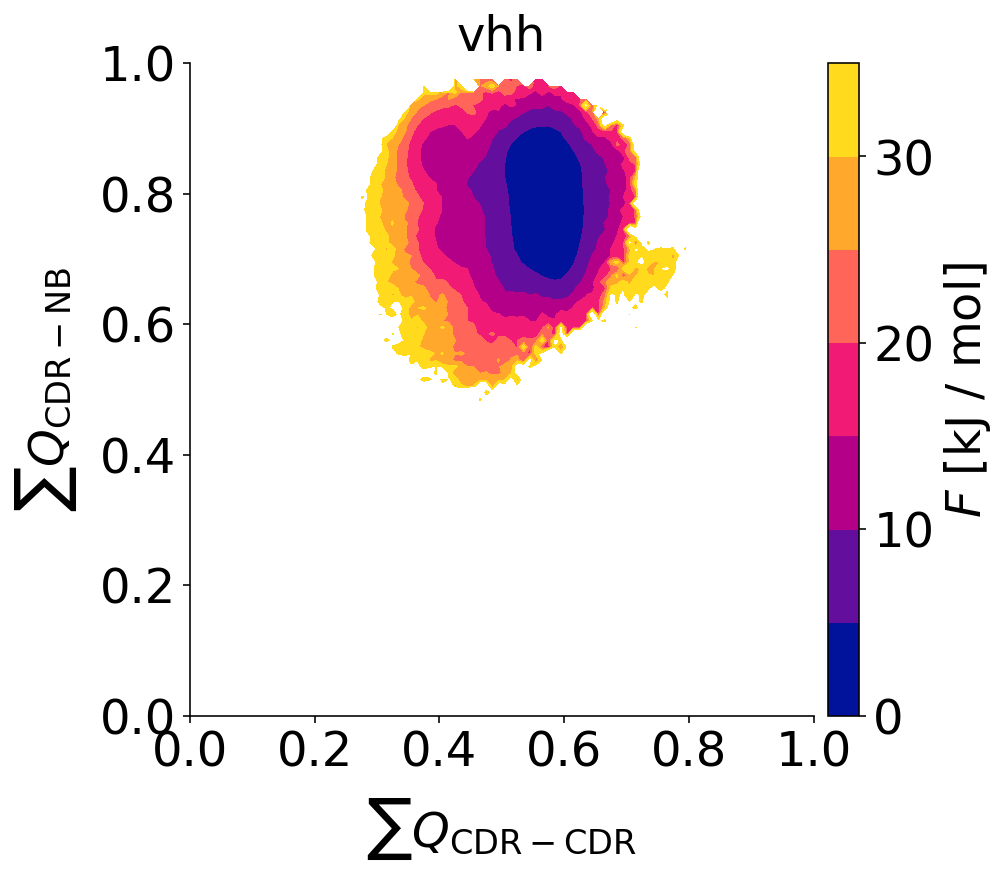

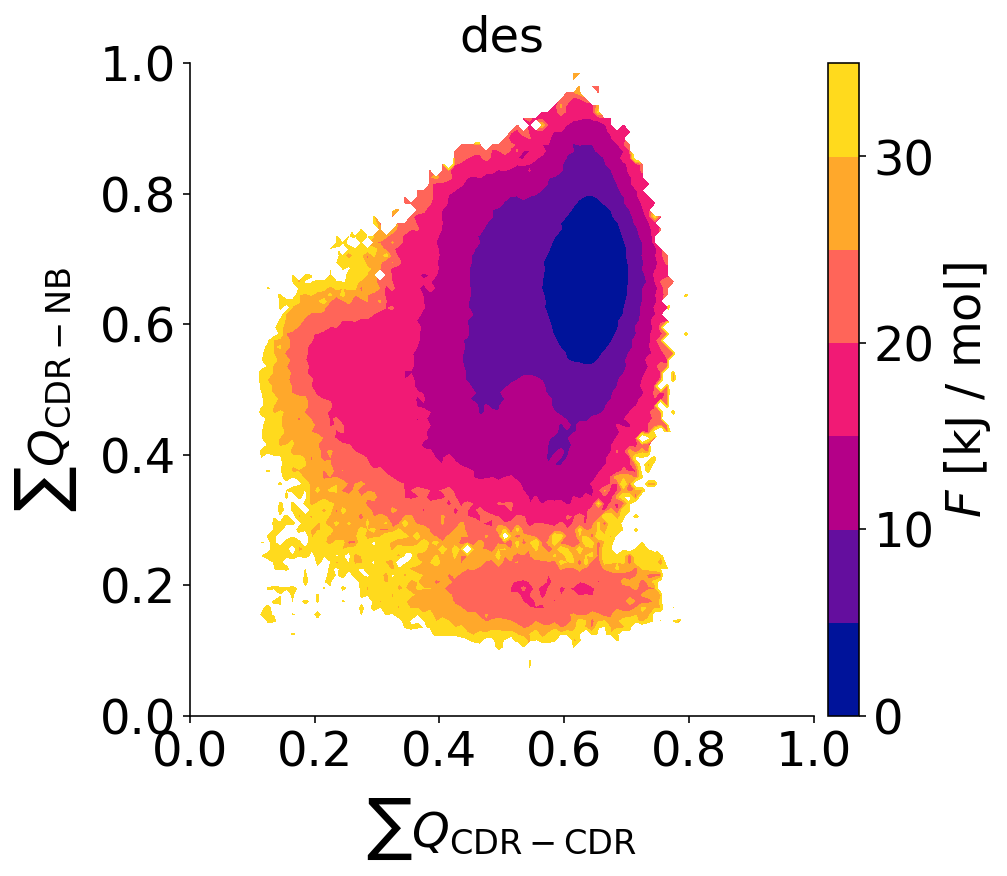

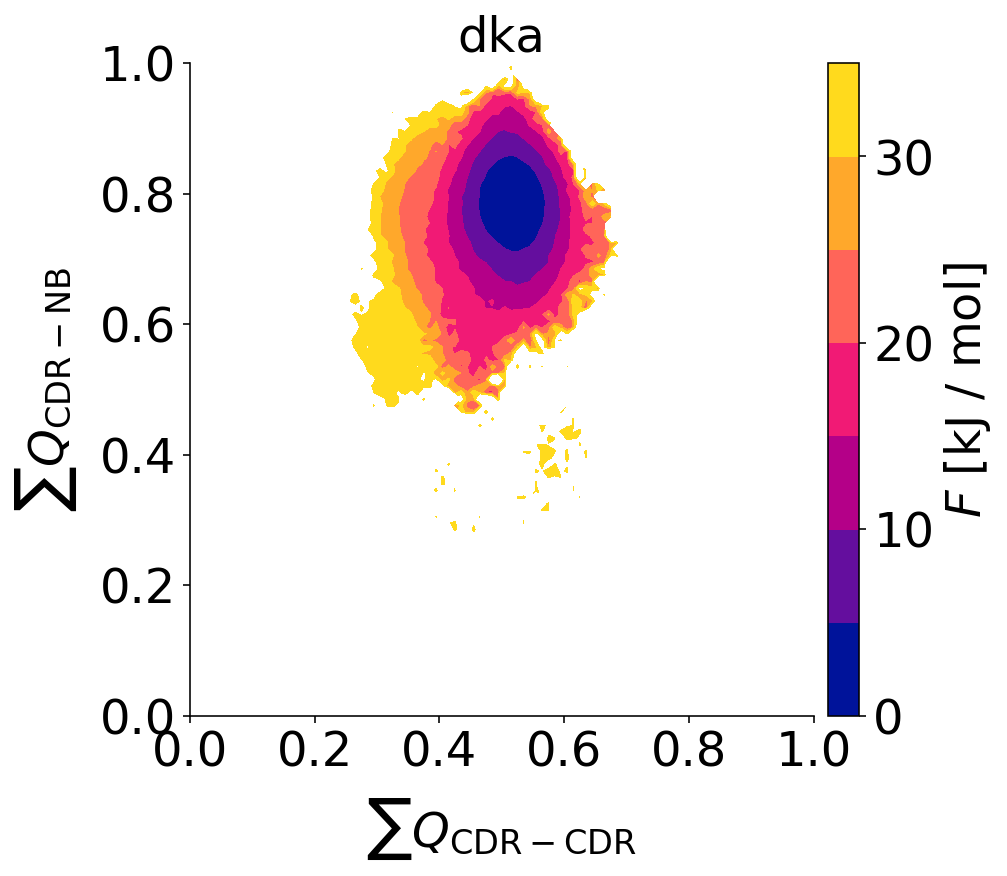

In [118]:
for k in ("vhh", "des", "dka"):
    nbins = 100
    hist, xes, yes = np.histogram2d(contacts[k][:, 0], contacts[k][:, 1], bins=nbins,
                                    density=True, weights=weights[k], range=((0, 1), (0, 1)))
    xe, ye = 0.5 * (xes[:-1] + xes[1:]), 0.5 * (yes[:-1] + yes[1:])
    xx, yy = np.meshgrid(xe, ye)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    cmap = cc.m_bmy
    F = -KBT * np.log(hist).T
    F -= F.min()
    cf = ax.contourf(xx, yy, F, np.arange(0.0, 40, 5), cmap=cmap)
    ax.set_xticks(np.arange(0, 1.2, 0.2))
    ax.set_yticks(np.arange(0, 1.2, 0.2))
    ax.tick_params(labelsize=24)
    ax.set_xlabel(r"$\sum Q_\mathrm{CDR-CDR}$", fontsize=24, labelpad=10)
    ax.set_ylabel(r"$\sum Q_\mathrm{CDR-NB}$", fontsize=24, labelpad=10)
    div = make_axes_locatable(ax)
    cax = div.append_axes("right", size="5%", pad=0.1)
    cb = fig.colorbar(cf, cax=cax)
    cb.set_label("$F$ [kJ / mol]", fontsize=24)
    cb.set_ticks(np.arange(0, 50, 10))
    cax.tick_params(labelsize=24)
    ax.set_title(k, fontsize=24)
    sns.despine(ax=ax)
    fig.savefig(f"figs/fes-con-{k}.svg", bbox_inches="tight")
    fig.savefig(f"figs/fes-con-{k}.pdf", bbox_inches="tight")

## Sample structures
From the full ensemble:

In [18]:
n_struct = 50
for k in ("vhh", "des", "dka"):
    inds_temp = np.arange(traj[k].n_frames, dtype=np.int)
    sample = np.random.choice(inds_temp, size=n_struct, replace=False, p=weights[k])
    traj[k][sample].save_pdb(f"structures/conf-{k}-all.pdb")

And from each cluster:

In [137]:
n_struct = 10
for k in ("vhh", "des", "dka"):
    centers = []
    for cidx in range(1, ids[k].max() + 1):
        fids = inds[k][i][ids[k][i] == cidx]
        if len(fids) < n_struct:
            continue
        w_clust = weights[k][fids]
        sample = np.random.choice(fids, size=n_struct, replace=False)
        centers.append(contacts[k][fids].mean(axis=0))
        traj[k][sample].save_pdb(f"structures/conf-{k}-c{cidx}.pdb")
    np.savetxt(f"structures/conf-{k}-loc.dat", np.array(centers))